<a href="https://colab.research.google.com/github/isasenth/cdle_youth_handson_nlp_1/blob/okazawa/fakenews_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==4.18.0 fugashi==1.1.0 ipadic==1.0.0 pytorch-lightning==1.6.1

import random
import glob
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
import pytorch_lightning as pl

# 日本語の事前学習モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

# データセット読み込み

In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv("/content/drive/MyDrive/nishika_fake-news/train.csv")
test = pd.read_csv("/content/drive/MyDrive/nishika_fake-news/test.csv")

submit = pd.read_csv("/content/drive/MyDrive/nishika_fake-news/sample_submission.csv")

# 前処理

https://note.com/narudesu/n/na35de30a583a

In [3]:
tqdm.pandas()
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

def text_to_token(text):
    # 事前学習で使ったトークナイザー
    wakati_ids = tokenizer.encode(text, return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(wakati_ids[0].tolist())
    return tokens


train['token'] = train['text'].apply(text_to_token)
train['token_num'] = train['token'].apply(lambda tokens: len(tokens))
train.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


,id,isFake,text,token,token_num
0,d19828eb64,1,Cによると、アメリカの元大統領で、最長寿だったジョージ・ウォーカー・ブッシュ氏が27日(C-...,"[[CLS], C, に, よる, と, 、, アメリカ, の, 元, 大統領, で, 、,...",720
1,dfaab096bd,0,中日新聞によると、コナミカップ・プロ野球アジアシリーズ2007の決勝戦・日本の中日ドラゴンズ...,"[[CLS], 中日, 新聞, に, よる, と, 、, コナミ, カップ, ・, プロ, ...",428
2,163504bf95,1,愛媛Cは、11月12日にリーグ準加盟の承認を受けて、来期リーグ加盟を目指す愛媛Cに対して、鈴...,"[[CLS], 愛媛, C, は, 、, 11, 月, 12, 日, に, リーグ, 準, ...",296
3,ed3c9dc579,0,国民日報によると3日、7時50分（UTC+9、日本時間と同じ）大韓民国京畿道平沢市の西海岸（...,"[[CLS], 国民, 日報, に, よる, と, 3, 日, 、, 7, 時, 50, 分...",385
4,e06f88267f,1,共同通信によると、5日午後2時過ぎから東京都、神奈川県、千葉県の3都県の広い範囲の地域で停電...,"[[CLS], 共同, ##通信, に, よる, と, 、, 5, 日, 午後, 2, 時,...",316


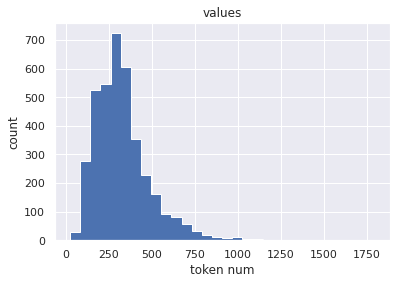

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

token_nums = train['token_num'].to_numpy()

plt.figure()
plt.hist(token_nums, bins=30, histtype='stepfilled')
plt.xlabel('token num')
plt.ylabel('count')
plt.title('values')
plt.show()

In [5]:
train['token_num'].describe()

count    3781.000000
mean      327.615181
std       164.426831
min        23.000000
25%       214.000000
50%       303.000000
75%       397.000000
max      1795.000000
Name: token_num, dtype: float64

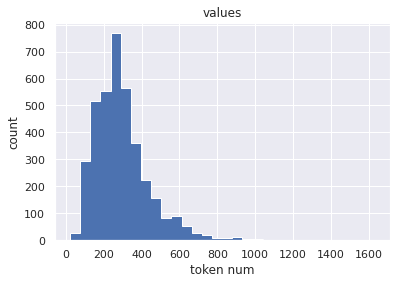

In [6]:
import re

def preprocessing(text):
    # 半角記号削除
    text = re.sub(r'\'[!"#$%&\'\\\\()*+,-./:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀＋￥％]', '', text)
    # 数値を全て 0 に変換
    text = re.sub(r'\d+', '0', text)
    # 大文字を小文字に統一
    text = text.lower()
    return text

train['text'] = train['text'].apply(preprocessing)
train['token'] = train['text'].apply(text_to_token)
train['token_num'] = train['token'].apply(lambda tokens: len(tokens))


token_nums = train['token_num'].to_numpy()

plt.figure()
plt.hist(token_nums, bins=30, histtype='stepfilled')
plt.xlabel('token num')
plt.ylabel('count')
plt.title('values')
plt.show()

In [7]:
train['token_num'].describe()

count    3781.000000
mean      295.040201
std       148.231615
min        21.000000
25%       193.000000
50%       273.000000
75%       357.000000
max      1630.000000
Name: token_num, dtype: float64

In [8]:
# ストップワード設定
# !wget http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt

# with open('Japanese.txt') as f:
#     stopwords = [w.strip() for w in f]
#     stopwords = set(stopwords)

# len(stopwords)

In [9]:
# def remove_stopwords(words):
#     words = [w for w in words if w not in stopwords]
#     return words

# train['token'] = train['token'].apply(remove_stopwords)
# train['text'] = train['token'].apply(lambda tokens: ' '.join(tokens).lstrip('[CLS]').rstrip('[SEP]'))
# train['text'] = train['text'].apply(lambda text: re.sub('#', '', text))
# train['token_num'] = train['token'].apply(lambda tokens: len(tokens))

# plt.figure()
# plt.hist(token_nums, bins=30, histtype='stepfilled')
# plt.xlabel('token num')
# plt.ylabel('count')
# plt.title('values')
# plt.show()

In [10]:
# train['token_num'].describe()

# 学習

In [11]:
def make_dataset(df, max_length, tokenizer):
  dataset = []
  for index, row in df.iterrows():
    encoding = tokenizer(
        row['text'],
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    encoding['labels']=row['isFake']
    encoding = { k: torch.tensor(v) for k, v in encoding.items() }
    dataset.append(encoding)
  return dataset

In [12]:
max_length = 256
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)

dataset_for_loader = make_dataset(train, max_length, tokenizer)
random.shuffle(dataset_for_loader)
n = len(dataset_for_loader)
n_train = int(0.7*n)
dataset_train = dataset_for_loader[:n_train]
dataset_val = dataset_for_loader[n_train:]
# dataset_test = make_dataset(test, max_length, tokenizer)

dataloader_train = DataLoader(
    dataset_train, batch_size=16, shuffle=True
)
dataloader_val = DataLoader(dataset_val, batch_size=256)
# dataloader_test = DataLoader(dataset_test, batch_size=256)

In [13]:
class BertForSequenceClassification_pl(pl.LightningModule):
        
    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters() 
        self.bert_sc = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        self.outputs = []
        
    def training_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        loss = output.loss
        self.log('train_loss', loss)
        return loss
        
    def validation_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log('val_loss', val_loss)

    def test_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        self.outputs.extend(labels_predicted.tolist())

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [14]:
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/',
)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=10,
    callbacks = [checkpoint]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
model = BertForSequenceClassification_pl(
    MODEL_NAME, num_labels=2, lr=1e-5
)

trainer.fit(model, dataloader_train, dataloader_val)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [16]:
best_model_path = checkpoint.best_model_path
print('ベストモデルのファイル: ', checkpoint.best_model_path)
print('ベストモデルの検証データに対する損失: ', checkpoint.best_model_score)

ベストモデルのファイル:  /content/model/epoch=5-step=996.ckpt
ベストモデルの検証データに対する損失:  tensor(0.0702, device='cuda:0')


# 予測

In [17]:
def make_dataset_test(df, max_length, tokenizer):
  dataset = []
  for index, row in df.iterrows():
    encoding = tokenizer(
        row['text'],
        max_length=max_length,
        padding='max_length',
        truncation=True
    )
    encoding = { k: torch.tensor(v) for k, v in encoding.items() }
    dataset.append(encoding)
  return dataset

In [18]:
test['text'] = test['text'].apply(preprocessing)
test['token'] = test['text'].apply(text_to_token)
# test['token_num'] = test['token'].apply(lambda tokens: len(tokens))

Token indices sequence length is longer than the specified maximum sequence length for this model (715 > 512). Running this sequence through the model will result in indexing errors


In [19]:
dataset_test = make_dataset_test(test, max_length, tokenizer)
dataloader_test = DataLoader(dataset_test, batch_size=256)
trainer.test(dataloaders=dataloader_test)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1445: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/model/epoch=5-step=996.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/model/epoch=5-step=996.ckpt


Testing: 0it [00:00, ?it/s]

[{}]

In [20]:
submit['isFake'] = model.outputs

In [21]:
submit.to_csv('/content/drive/MyDrive/nishika_fake-news/prepro2_bert_256_16.csv', index=False)